# C3M1: Peer Reviewed Assignment

### Outline:
The objectives for this assignment:

1. Apply Binomial regression methods to real data.
2. Understand how to analyze and interpret binomial regression models.
3. Flex our math skills by determining whether certain distributions are members of the exponential family.

General tips:

1. Read the questions carefully to understand what is being asked.
2. This work will be reviewed by another human, so make sure that you are clear and concise in what your explanations and answers.

In [1]:
# Load required libraries
library(tidyverse)
library(dplyr)
library(ggplot2)
library(plyr)
oldw <- getOption("warn")
options(warn = -1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following object is masked from ‘package:purrr’:

    compact




## Problem 1: Binomial (Logistic) Regression

The National Institute of Diabetes and Digestive and Kidney Diseases conducted a study of 768 adult female Pima Indians living near Phoenix, AZ. The purpose of the study was to investigate the factors related to diabetes. 

*Before we analyze these data, we should note that some have raised ethical issues with its collection and popularity in the statistics and data science community. We should think seriously about these concerns. For example, Maya Iskandarani wrote a brief [piece](https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/) on consent and privacy concerns raised by this dataset. After you familarize yourself with the data, we'll then turn to these ethical concerns.*


First, we'll use these data to get some practice with GLM and Logistic regression.

In [2]:
# Load the data
pima = read.csv("pima.txt", sep="\t")
# Here's a description of the data: https://rdrr.io/cran/faraway/man/pima.html
head(pima)

,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age,test
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<int>,<int>
1,6,148,72,35,0,33.6,0.627,50,1
2,1,85,66,29,0,26.6,0.351,31,0
3,8,183,64,0,0,23.3,0.672,32,1
4,1,89,66,23,94,28.1,0.167,21,0
5,0,137,40,35,168,43.1,2.288,33,1
6,5,116,74,0,0,25.6,0.201,30,0


In [3]:
#pima$test<-as.factor(pima$test)

In [4]:
str(pima)

'data.frame':	768 obs. of  9 variables:
 $ pregnant : int  6 1 8 1 0 5 3 10 2 8 ...
 $ glucose  : int  148 85 183 89 137 116 78 115 197 125 ...
 $ diastolic: int  72 66 64 66 40 74 50 0 70 96 ...
 $ triceps  : int  35 29 0 23 35 0 32 0 45 0 ...
 $ insulin  : int  0 0 0 94 168 0 88 0 543 0 ...
 $ bmi      : num  33.6 26.6 23.3 28.1 43.1 25.6 31 35.3 30.5 0 ...
 $ diabetes : num  0.627 0.351 0.672 0.167 2.288 ...
 $ age      : int  50 31 32 21 33 30 26 29 53 54 ...
 $ test     : int  1 0 1 0 1 0 1 0 1 1 ...


### 1. (a) Data Cleaning? What about Data Scrubbing? Data Sterilizing?

This is a real data set, which means that there's likely going to be gaps and missing values in the data. Before doing any modeling, we should inspect the data and clean it if necesary.

Perform simple graphical and numerical summaries of the data. Pay attention for missing or nonsensical values. Can you find any obvious irregularities? If so, take appropriate steps to correct these problems. In the markdown cell, specify what cleaning you did and why you did it.

Finally, split your data into training and test sets. Let the training set contain $80\%$ of the rows and the test set contain the remaining $20\%$.

### Observations:

Research has established that healthy people have basal insulin values of 5 to 15 microunits per milliliter of blood.

Data report some values insulin like 0

### Numerical summarie and Simple graphical 


In [5]:
pima %>%
  group_by(test) %>%
  summarise_at(vars(everything()), funs(mean(., na.rm=TRUE)))

test,pregnant,glucose,diastolic,triceps,insulin,bmi,diabetes,age
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3.298000,109.9800,68.18400,19.66400,68.7920,30.30420,0.429734,31.19000
1,4.865672,141.2575,70.82463,22.16418,100.3358,35.14254,0.550500,37.06716


From the last table,

we identify two important variables: Glucose and Insuline.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



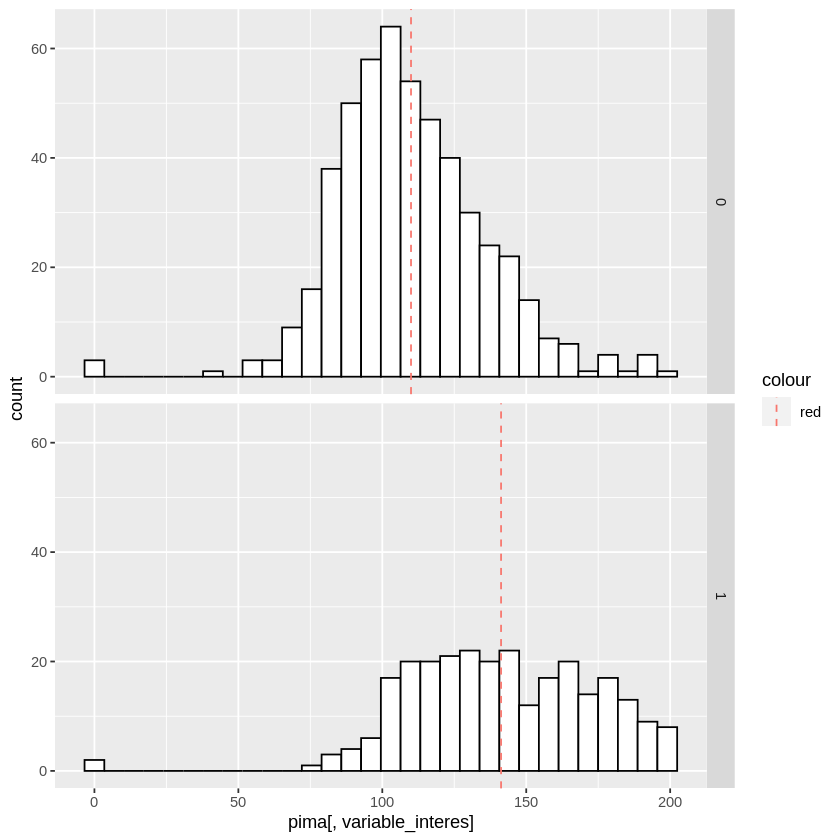

In [6]:
variable_interes <-'glucose'

# Graph of "glucose"
media = pima %>%
  group_by(test) %>%
  summarise_each(funs(mean), as.name(variable_interes)) #%>% pull(group_means)
  
p<-ggplot(pima, aes(x=pima[,variable_interes]))+
  geom_histogram(color="black", fill="white")+
  facet_grid(test ~ .)
p+geom_vline(data=media, aes(xintercept=glucose, color="red"),linetype="dashed")

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



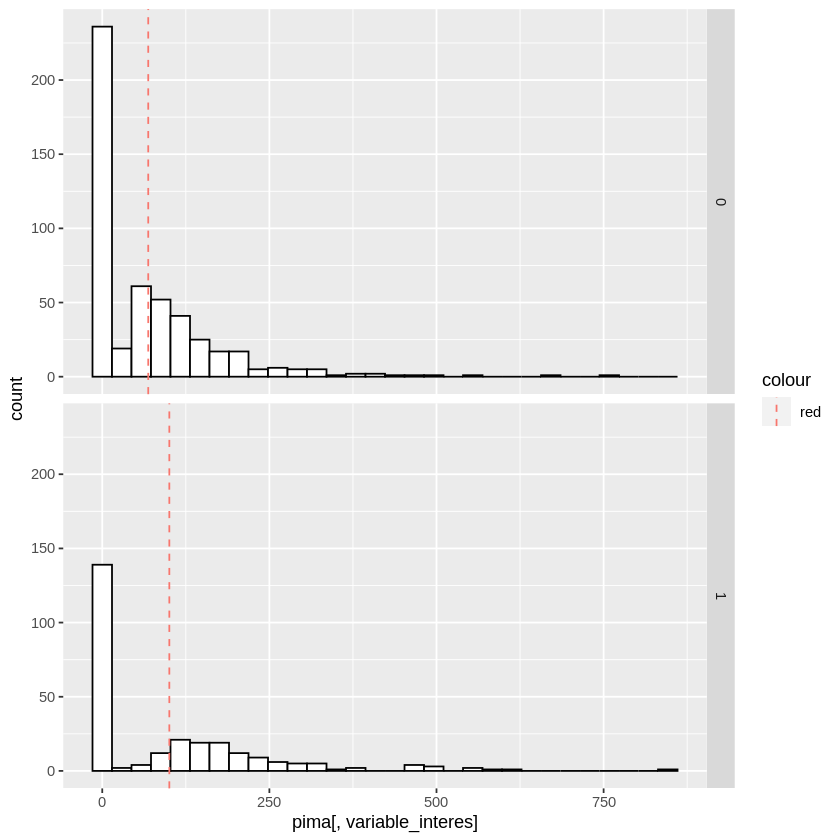

In [7]:
variable_interes <-"insulin"

# Graph of "glucose"
media = pima %>%
  group_by(test) %>%
  summarise_each(funs(mean), as.name(variable_interes)) #%>% pull(group_means)

p<-ggplot(pima, aes(x=pima[,variable_interes]))+
  geom_histogram(color="black", fill="white")+
  facet_grid(test ~ .)
p+geom_vline(data=media, aes(xintercept=insulin, color="red"),linetype="dashed")
#p+geom_vline(xintercept = media)

### Delete outliers 


In [8]:
#function to get outliers
get_outliers = function(x){
   which(x > quantile(x)[4] + 1.5*IQR(x) | x < quantile(x)[2] - 1.5*IQR(x))
}

In [9]:
#delete outliers to variables glucose, diastolic, triceps and bmi
outliers <- get_outliers(pima$glucose)
pima_1 = pima[-outliers,]
outliers <- get_outliers(pima_1$diastolic)
pima_2 = pima_1[-outliers,]
outliers <- get_outliers(pima_2$triceps)
pima_3 = pima_2[-outliers,]
outliers <- get_outliers(pima_3$bmi)
pima_4 = pima_3[-outliers,]

dim(pima_4)
#we have a dataframe with 708 observations

[1] 708   9

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



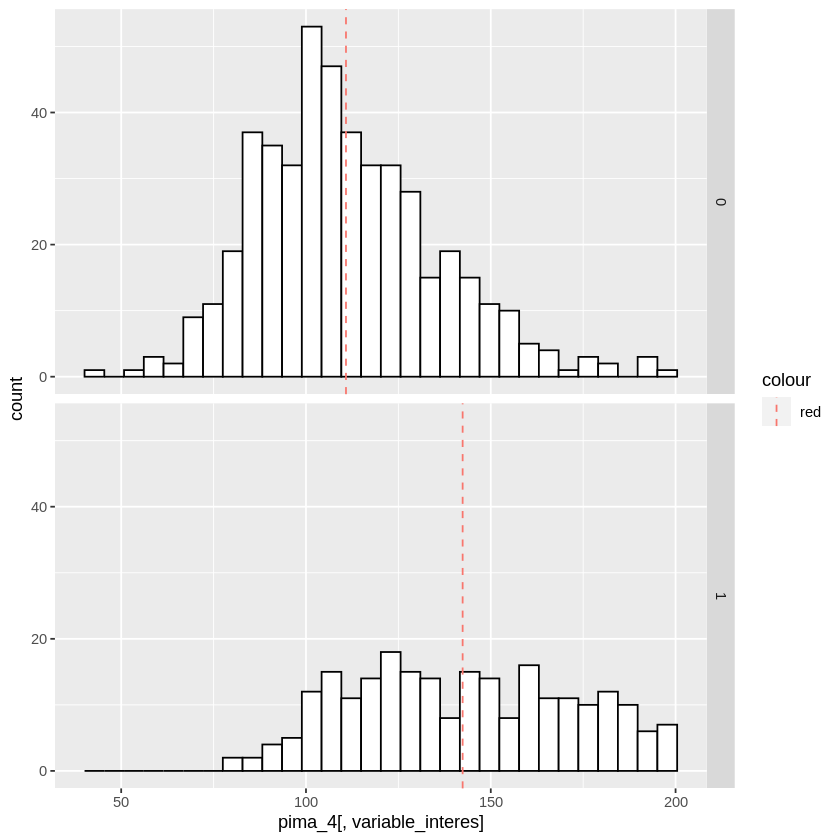

In [10]:
### Example of Delete outliers 
variable_interes <-'glucose'

# Graph of "glucose"
media = pima_4 %>%
  group_by(test) %>%
  summarise_each(funs(mean), as.name(variable_interes)) #%>% pull(group_means)

p<-ggplot(pima_4, aes(x=pima_4[,variable_interes]))+
  geom_histogram(color="black", fill="white")+
  facet_grid(test ~ .)
p+geom_vline(data=media, aes(xintercept=glucose, color="red"),linetype="dashed")
#p+geom_vline(xintercept = media)

### Split training set - test set ( 80% -20% )

In [11]:
set.seed(1)
sample <- sample(c(TRUE, FALSE), nrow(pima_4), replace=TRUE, prob=c(0.8,0.2))
train_data  <- pima_4[sample, ]
test_data   <- pima_4[!sample, ]

### 1. (b) Initial GLM modelling


Our data is clean and we're ready to fit! What kind of model should we use to fit these data? Notice that the `test` variable is either $0$ or $1$, for whether the individual tested positive for diabetes. Because `test` is binary, we should use logistic regression (which is a kind of binomial regression).

Fit a model with `test` as the response and all the other variables as predictors. Can you tell whether this model fits the data?

In [12]:
logit <- glm(test ~ ., data = train_data, family = "binomial")

In [13]:
summary(logit)


Call:
glm(formula = test ~ ., family = "binomial", data = train_data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.6826  -0.7015  -0.4041   0.7227   2.2188  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept) -9.8556891  1.0525424  -9.364  < 2e-16 ***
pregnant     0.1121623  0.0372476   3.011  0.00260 ** 
glucose      0.0361440  0.0044164   8.184 2.74e-16 ***
diastolic    0.0002658  0.0108330   0.025  0.98043    
triceps     -0.0049189  0.0085415  -0.576  0.56469    
insulin     -0.0006403  0.0010652  -0.601  0.54777    
bmi          0.1022034  0.0203923   5.012 5.39e-07 ***
diabetes     0.9785875  0.3404780   2.874  0.00405 ** 
age          0.0153760  0.0113802   1.351  0.17666    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 732.82  on 568  degrees of freedom
Residual deviance: 527.31  on 560  degrees of freedom
AIC: 545.31

Num

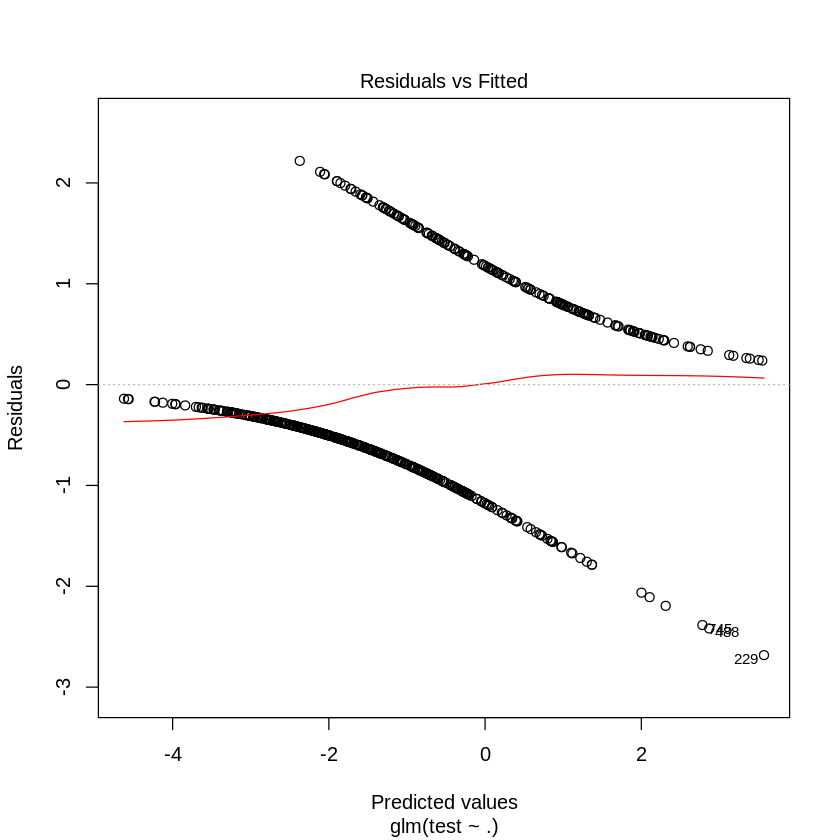

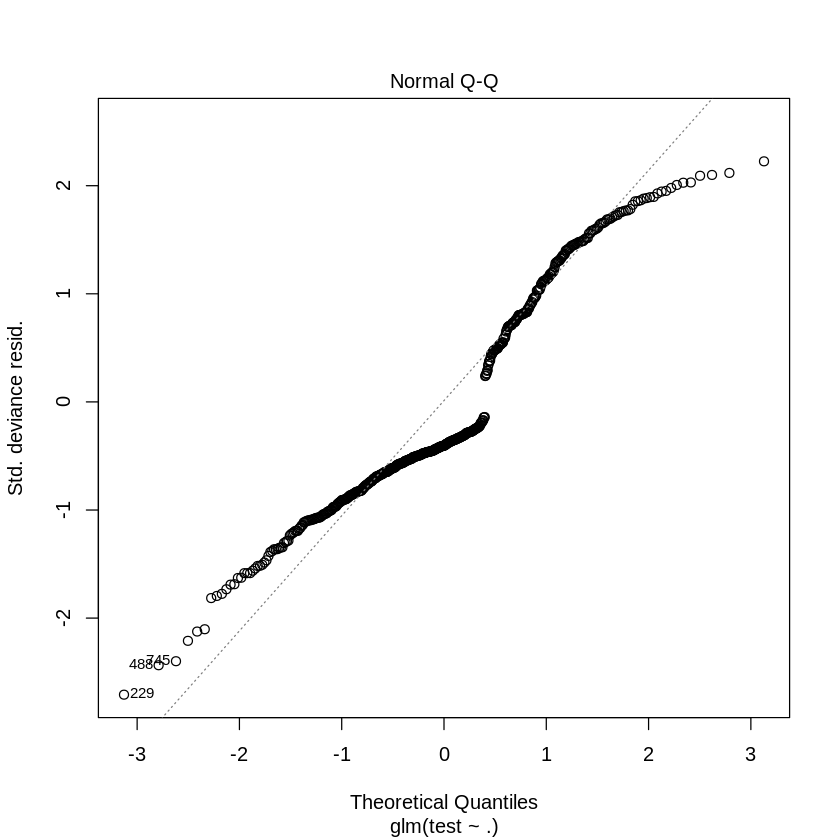

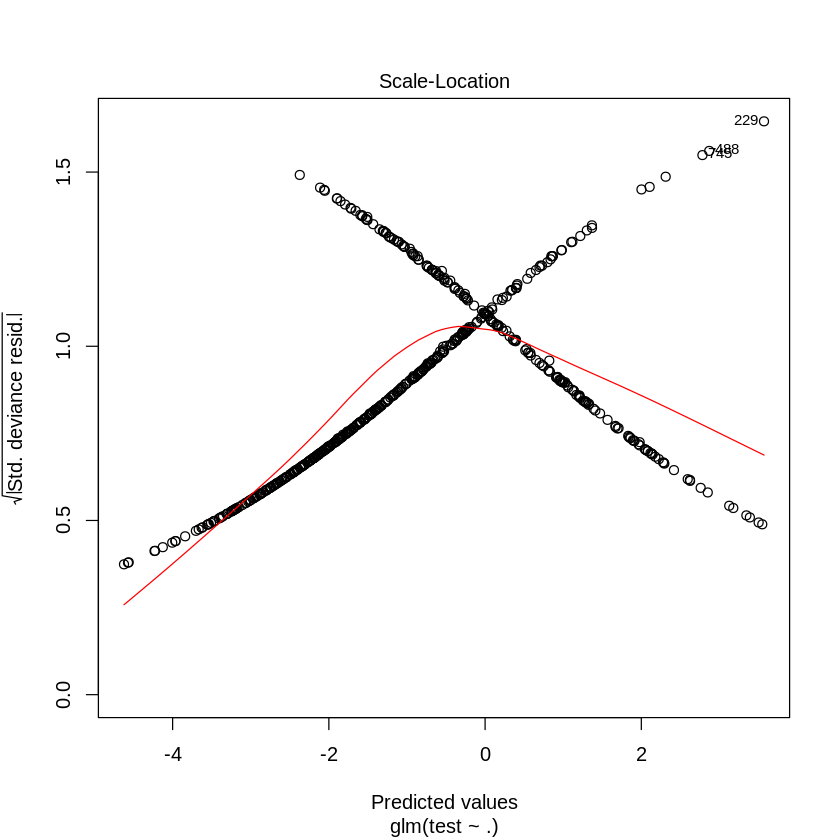

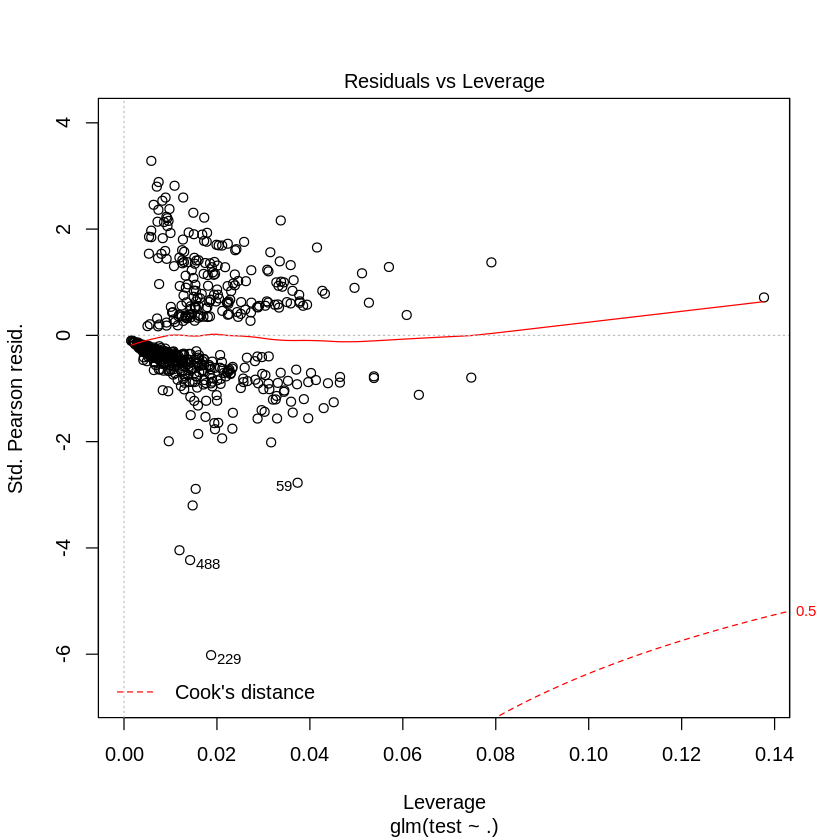

In [14]:
plot(logit)

The model shows some slightly skewed residuals but they appear acceptable.

We also observe that the most important variable is glucose.

### 1. (c) Remember Bayes

A quick analytical interlude.

Is diastolic blood pressure significant in the regression model? Do women who test positive have higher diastolic blood pressures? Explain the distinction between the two questions and discuss why the answers are only apparently contradictory.

###### ¿is diastolic blood pressure significant in the regression model?

answer: Diastolic blood pressure is not significant in the regression model.

###### ¿Do women who test positive have higher diastolic blood pressures?

In [16]:
test_1<-train_data[train_data$test==1,]
test_0<-train_data[train_data$test==0,]

x_1<-test_1$diastolic
x_0<-test_0$diastolic

t.test(x_1, x_0,alternative = c("two.sided"),conf.level = 0.95)


	Welch Two Sample t-test

data:  x_1 and x_0
t = 3.8265, df = 411.64, p-value = 0.0001501
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 1.744845 5.431415
sample estimates:
mean of x mean of y 
 74.45408  70.86595 


Yes, according to the hypothesis test, diastolic pressure is higher in women who tested positive.

The answers are not contradictory, it is just that in the first case we are observing all the variables together while in the second hypothesis test it is the observation of a single variable.

Other factors are the mulicolinearity that could exist with other variables.

### 1. (d) GLM Interpretation

We've seen so many regression summaries up to this point, how is this one different from all the others? Well, to really understand any model, it can be helpful to loop back and plug the fitted results back into the model's mathematical form.

Explicity write out the equation for the binomial regression model that you fit in (b). Then, in words, explain how a $1$ unit change of `glucose` affects `test`, assuming all other predictors are held constant.

if $ log(\frac{p(x)}{1-p(x)}) = \beta_0 + \beta_1 x_1 $

$ \Rightarrow \frac{p(x)}{1-p(x)} = e^{\beta_0 + \beta_1 x_1} = odds(x)$

$ \Rightarrow OR ={\frac {\operatorname {odds} (x+1)}{\operatorname {odds} (x)}}={\frac {\left({\frac {p(x+1)}{1-p(x+1)}}\right)}{\left({\frac {p(x)}{1-p(x)}}\right)}}={\frac {e^{\beta _{0}+\beta _{1}(x+1)}}{e^{\beta _{0}+\beta _{1}x}}}=e^{\beta _{1}}$

if $\beta_{glucose} = 0.0361440$

$e^{0.0361440} = 1.0368$

A one-unit increase in glucose increases the chance of testing positive by 1.03 times.

In [62]:
exp(0.0361440)*100 -100

[1] 3.680514

### 1. (e) GLM Prediction

One of the downsides of Logistic Regression is that there isn't an easy way of evaulating the goodness of fit of the model without predicting on new data. But, if we have more data to test with, then there are many methods of evaluation to use. One of the best tools are confusion matrices, which (despite the name) are actually not that hard to understand.

A confusion matrix compares the predicted outcomes of a Logistic Regression Model (or any classification model) with the actual classifications. For binary classification, it is a $2 \times 2$ matrix where the rows are the models' predicted outcome and the columns are the actual classifications. An example is displayed below.

|  | True | False |  
| --- | --- | --- |
| 1 | 103 | 37 |  
| 0 | 55  | 64 |  

In the example, we know the following information:
* The [1,1] cell is the number of datapoints that were correctly predicted to be $1$. The value (103) is the number of True Positives (TP). 
* The [2,2] cell is the number of datapoints that were correctly predicted to be $0$. The value is the number of True Negatives (TN).
* The [1, 2] cell is the number of datapoints that were predicted to be $1$ but where actually $0$. This is the number of False Positives (FP), also called Type I error. In the context of our diabetes dataset, this would mean our model predicted that the person would have diabetes, but they actually did not.
* The [2, 1] cell is the number of datapoints that were predicted to be $0$ but where actually $1$. This is the number of False Negatives (FN), also called Type 2 error. In the context of our diabetes dataset, this would mean our model predicted that the person would not have diabetes, but they actually did have diabetes.

Use your model to predict the outcomes of the test set. Then construct a confusion matrix for these predictions and display the results.

In [20]:
pdata <- predict(logit, newdata = test_data, type = "response")
table(as.factor(as.numeric(pdata>0.5)),as.factor(test_data$test>=1))

   
    FALSE TRUE
  0    84   17
  1    11   27

### 1. (f) Evaluation Statistics

Using the four values from the confusion matrix, we can construct evaulation statistics to get a numerical approximation for our model's performance. Spend some time researching accuracy, precision, recall and F score. 

Calculate these values for your model's predictions on the test set. Clearly display your results. How well do you think your model fits the data?

In [26]:
cm <- table(as.factor(as.numeric(pdata>=0.5)),as.factor(test_data$test>=1))
accuracy <- sum(cm[1], cm[4]) / sum(cm[1:4])
precision <- cm[4] / sum(cm[4], cm[2])
sensitivity <- cm[4] / sum(cm[4], cm[3])
fscore <- (2 * (sensitivity * precision))/(sensitivity + precision)
specificity <- cm[1] / sum(cm[1], cm[2])
##
print(paste('Accuracy:',accuracy))
print(paste('Precision:',precision))
print(paste('Sensitivity or Recall:',sensitivity))
print(paste('F-Score:',fscore))

[1] "Accuracy: 0.798561151079137"
[1] "Precision: 0.710526315789474"
[1] "Sensitivity or Recall: 0.613636363636364"
[1] "F-Score: 0.658536585365854"


The `accuracy value is 0.79` and indicates that 79 out of 100 records are classified correctly.
The `precision is 0.71` indicates how many positive data are correctly predicted from those that were predicted as positive.
The `recall is 0.61` indicating how many positive data are correctly predicted from those that are positive.
The f1 score metric considers the values 'precision' and 'sensitivity' to weight an intermediate value, for the case study `f1 is 0.65`

### 1. (g) Understanding Evaluation Statistics

Answer the following questions in the markdown cell below.

1. Give an example scenario for when accuracy would be a misleading evaulation statistic.
2. Confusion matrices can also be used for non-binary classification problems. Describe what a confusion matrix would look like for a response with $3$ levels.
3. You'll have to take our word on the fact (or spend some time researching) that Type I error and Type II error are inversely related. That is, if a model is very good at detecting false positives, then it will be bad at detecting false negatives. In the case of our diabetes dataset, would you prefer a model that overestimates the Type 1 error or overestimates the Type II error. Justify your answer.

##### Answer question 1:

|  | True | False |  
| --- | --- | --- |
| 1 | 220 | 20 |  
| 0 | 10  | 2 | 

222/252 = 0.88

In the example the accuracy is equal to 0.88 (looks good) but the model is unable to predict negative cases.

##### Answer question 2:

An example it could be:

|  | -1 | 0 | 1 |  
| --- | --- | --- |--- |
| -1 | 220 | 5 |10|  
| 0 | 10  | 20 | 4|
| 1 | 0 | 5 |50|  


##### Answer question 3:

The type 1 error can be interpreted as the probability that the patient does not have diabetes and the model indicates that he does have diabetes, the type error indicates occurs when the model determines that the client does not have diabetes when in reality he does.

It depends on the application, both errors are equally important; In the case of type 1 error, it is not pleasant to be told "you have diabetes", start treatment, spend money and simply be wrong.

In the case of type II error, in diseases the reaction time is important to prevent the disease from evolving, so giving a false negative can be crucial for intervention times.

### 1. (h) Ethical Issues in Data Collection

Read Maya Iskandarani's [piece](https://researchblog.duke.edu/2016/10/24/diabetes-and-privacy-meet-big-data/) on consent and privacy concerns raised by this dataset. Summarize those concerns here.

##### Answer:

Accepting the terms and conditions can be dangerous, the answer you give today may not be the same in the future, and at the moment you make the decision you cannot assimilate the future repercussions.

For example, the data of people from Arizona continues to be used today even though 40 years have passed.

## Problem 2: Practicing those Math skills

One of the conditions of GLMs is that the "random component" of the data needs to come from the Exponential Family of Distributions. But how do we know if a distribution is in the Exponential Family? Well, we could look it up. Or we could be proper mathematicians and check the answer ourselves! Let's flex those math muscles.

### 2. (a) But it's in the name...

Show that $Y \sim exponential(\lambda)$, where $\lambda$ is known, is a member of the exponential family.

$f_Y(y) =  \frac{1}{\lambda} e ^{- \frac{y}{\lambda}}$

 $ \Rightarrow log(f_Y(y)) = log(\frac{1}{\lambda}) + log(e ^{- \frac{y}{\lambda}})$

 $ \Rightarrow log(f_Y(y)) = log(1) - log(\lambda)  + ({- \frac{y}{\lambda}}) log(e)$
 
  $ \Rightarrow exp(𝑙𝑜𝑔(𝑓𝑌(𝑦)))= exp( (y) (- \frac{1}{\lambda})   - log(\lambda) + log(1)  ) $
  
  
 Donde; $\theta =  -\frac{1}{\lambda} $ ;  $b(\theta) = log(\lambda ) $ ; $c(y,\phi) = log(1)$

### 2. (b) Why can't plants do math? Because it gives them square roots!

Let $Y_i \sim exponential(\lambda)$ where $i \in \{ 1, \dots, n\}$. Then $Z = \sum_{i=1}^n Y_i \sim Gamma(n, \lambda)$. Show that $Z$ is also a member of the exponential family.

$f_Y(y|n,\lambda) =  \frac{\lambda^{n}}{\Gamma(n)} y^{n-1} exp(-\lambda y) $

$ \Rightarrow f_Y(y|n,\lambda) =  y^{-1} \frac{\lambda^{n}}{\Gamma(n)} y^{n}  exp(-\lambda y) $

$ \Rightarrow f_Y(y|n,\lambda) =  y^{-1} exp(-\lambda y + log(\frac{\lambda^{n}}{\Gamma(n)}) + log(y^{n})  ) $

$ \Rightarrow f_Y(y|n,\lambda) =  y^{-1} exp[-\lambda y + n log({\lambda})- log({\Gamma(n)}) + {n} log(y)  ] $



Donde; $\theta =  {\lambda} $ ;  $b(\theta) = log(\lambda ) $ 